### DQN Learning @ cart-pole environment 
Source:
https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html
Cart-Pole dynamics
https://underactuated.mit.edu/acrobot.html

In [12]:
import gymnasium as gym
import numpy as np
import time

In [13]:
env = gym.make('CartPole-v1',render_mode="human")
state, _ = env.reset()
state

array([ 0.01913217,  0.02546447, -0.02770322, -0.04877048], dtype=float32)

In [14]:
env.render()

In [15]:
env.step(0)

(array([ 0.01964146, -0.1692495 , -0.02867863,  0.23504472], dtype=float32),
 1.0,
 False,
 False,
 {})

In [14]:
env.spec

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'human'}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.3.1
True


In [8]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class ReplayMemory(object):
  def __init__(self, capacity):
    self.memory = deque([],maxlen=capacity)
  def push(self, *args):
    self.memory.append(Transition(*args))
  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)
  def __len__(self):
    return len(self.memory)


In [9]:
class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(n_observations, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, n_actions)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [19]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [20]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n 
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR,amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [21]:
def select_action(state):
  global steps_done
  sample = random.random()
  epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY) # epsilon-greedy 
  steps_done += 1
  if sample > epsilon:
    with torch.no_grad():
      return policy_net(state).max(1).indices.view(1,1)
  else:
    return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [22]:
episode_durations = []

In [31]:
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
is_ipython = 'inline' in matplotlib.get_backend()
plt.ion()

In [29]:
def plot_durations(show_result=False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)
  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())
  if len(durations_t) >= 100:
    means = durations_t.unfold(0,100,1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99),means))
    plt.plot(means.numpy())
  
  plt.pause(0.001)
  if not show_result:
    display.display(plt.gcf())
    display.clear_output(wait=True)
  else:
    display.display(plt.gcf())
  

In [26]:
def optimize_model():
  if len(memory) < BATCH_SIZE:
    return
  transitions = memory.sample(BATCH_SIZE)
  batch = Transition(*zip(*transitions))

  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)

  next_state_values = torch.zeros(BATCH_SIZE, device=device)
  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values.detach()

  expected_state_action_values = (next_state_values * GAMMA) + reward_batch

  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  optimizer.step()

Complete


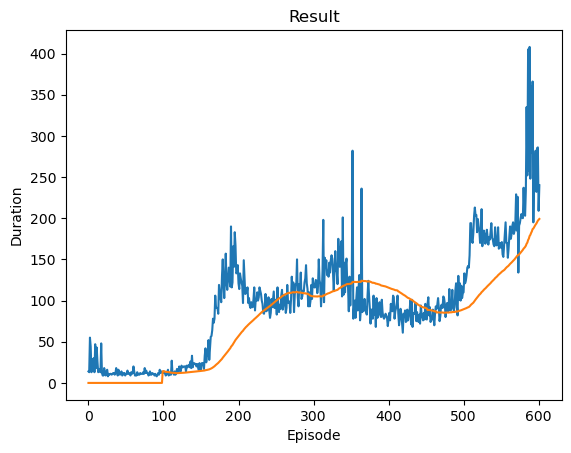

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

from itertools import count

for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()